In [1]:
## Import packages
%matplotlib inline
import numpy as np
import scipy.constants as sc
import scipy.sparse as sp
from qutip import *
import matplotlib.pyplot as plt
import math
font_size = 10
font_family = 'serif'
# Set Font Parameters
font = {'family': font_family, 'size': font_size}
plt.rc('font', **font)

In [2]:
## Dimensional operators
cav_dim = 10 # total number of possible photons
atm_dim = 2 # energy levels in the atom, 2 for TLS
I_cav = qeye(cav_dim) # identity matrix matching dimension of radiation field (2, one for vacuum state, one for excited states)
I_atom = qeye(atm_dim) # identity matrix matching dimension of spin system

## Atomic basis states
one, three = basis(2,0), basis(2,1) ## correponds to X and Z levels

## Atomic raising and lowering operators
sigmap = one * three.dag() # raising from three to one
sigmam = three * one.dag() # lowering from one to three
sigmap_tot = tensor(sigmap, I_cav)
sigmam_tot = tensor(sigmam, I_cav)

## Atomic inversion operators
sigmaz = commutator(sigmap, sigmam)
sigmaz_tot = commutator(sigmap_tot, sigmam_tot)

## Photon operators
adag = create(cav_dim)
a = destroy(cav_dim)
adag_tot = tensor(I_atom, adag) # order of arguments is important and is consistant with the spin operators #add .unit()               
a_tot = tensor(I_atom, a)

## Physical constants
N = 7e14 # number of two-level systems
gs = 2 * np.pi * 0.042e-6 # collective spin-photon couling strength ~ np.sqrt(tls_num)*g, experimetnally it's 1.1 though.
g = 2.5 # test spin-photon couling strength ~ np.sqrt(tls_num)*gs, experimetnally it's 1.1 though.
wa = 2 * np.pi * 1.45e3 # atom transition frequency between levels X & Z (MHz)
wc = 2 * np.pi * 1.45e3 # cavity frequency with vacuum field energy set to zero (zero-point energy) (MHz)

Kc = 0.1 # 2 * np.pi * 0.18 # cavity mode decay rate (MHz) # derivation can be found in Agarwal pg.31
Ks = 0.1 #2 * np.pi * 0.11 # spin dephasing rate (MHz)
gamma_13 = 0.1 # 2 * np.pi * 0.011 # spin-lattice relaxation rate between X and Z

## Initial quantum states
psi_atm = np.sqrt(1)*one + np.sqrt(0)*three
psi_phot = np.sqrt(1)*fock(10, 5)
psi0 = tensor(psi_atm, psi_phot)
rho = ket2dm(psi0) # composite density matrix

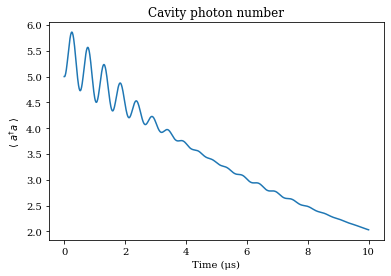

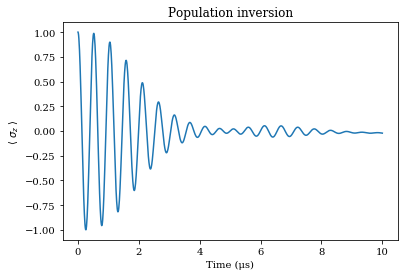

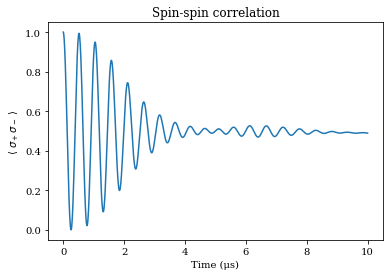

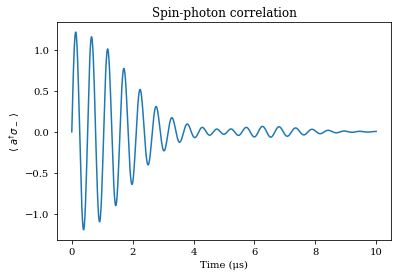

In [3]:
## Simulation initialization
time = 10 # duration of evolution
step_num = 1000 # number of steps to be used in evolution
tlist = np.linspace(0, time, step_num) # time points and duration of evolution
step_size = tlist[1] - tlist[0]

## Observable initialization
n_phot_list = [((adag * a) * rho.ptrace(1)).tr()] # number of photons in light field
inversion13_list = [(sigmaz * rho.ptrace(0)).tr()] # population inversion operator 
spin_spin13_list = [((sigmap * sigmam) * rho.ptrace(0)).tr()] # spin-spin correlation
spin13_phot_list = [((adag_tot * sigmam_tot) * rho).tr()] # spin-photon correlation

## function computing the Lindblad master equation
def lindblad(p):
    
    ## Hamiltonian for a single atom
    HA = 0.5*wa*sigmaz_tot #atomic part
    HF = wc*adag_tot*a_tot #field part
    HI = sigmap_tot*a_tot + sigmam_tot*adag_tot #interaction part in the RWA
    H = HA + HF + g*HI
    
    ## Liouvillian
    closed_system = -1j * commutator(H,p)
    cavity_decay = Kc/2 * (adag_tot*a_tot*p - 2*a_tot*p*adag_tot + p*adag_tot*a_tot)
    spin_relax13 = gamma_13/2 * (sigmap_tot*sigmam_tot*p - 2*sigmam_tot*p*sigmap_tot + p*sigmap_tot*sigmam_tot) #relaxation rate X to Z
    spin_dephase13 = Ks/2 * (sigmaz_tot.dag()*sigmaz_tot*rho - 2*sigmaz_tot*rho*sigmaz_tot.dag() + rho*sigmaz_tot.dag()*sigmaz_tot)
    
    
    return closed_system - cavity_decay #- spin_relax13 - spin_dephase13

## RK4 method realized using a for loop
for step_index in range(step_num-1):
    
    ## RK4 method
    k1 = step_size * lindblad(rho)
    k2 = step_size * lindblad(rho + 0.5*k1)
    k3 = step_size * lindblad(rho + 0.5*k2)
    k4 = step_size * lindblad(rho + k3)
    rho += 1/6*k1 + 1/3*(k2+k3) + 1/6*k4 # calculation of density matrix at n+1 step
    
#     #RK2 method
#     rho_pred = rho + 3/4 * lindblad(rho, N) * step_size # Predictor
#     rho_dash = rho_pred - 5/12 * lindblad(rho, N) * step_size
#     rho = rho_dash + 2/3 * lindblad(rho, N) * step_size # Corrector
    
    
    ## calculating observables at n+1 step using density matrix found above and adding them to list 
    n_phot_new = (((adag*a) * rho.ptrace(1)).tr().real)
    n_phot_list = np.append(n_phot_list, n_phot_new)
    
    inversion13_new = (sigmaz * rho.ptrace(0)).tr().real
    inversion13_list = np.append(inversion13_list, inversion13_new)
    
    spin_spin13_new = ((sigmap * sigmam) * rho.ptrace(0)).tr().real
    spin_spin13_list = np.append(spin_spin13_list, spin_spin13_new)
    
    spin13_phot_new = ((adag_tot * sigmam_tot) * rho).tr().imag
    spin13_phot_list = np.append(spin13_phot_list, spin13_phot_new)

    
## Visualization
plt.figure(figsize=(6,4))
plt.figure(1)
plt.plot(tlist, n_phot_list)
plt.title('Cavity photon number')
plt.ylabel('⟨ ${a^\dag}a$ ⟩')
plt.xlabel('Time (μs)')

plt.figure(figsize=(6,4))
plt.figure(2)
plt.plot(tlist, inversion13_list)
plt.title('Population inversion')
plt.ylabel('⟨ ${σ_z}$ ⟩')
plt.xlabel('Time (μs)')

plt.figure(figsize=(6,4))
plt.figure(3)
plt.plot(tlist, spin_spin13_list)
plt.title('Spin-spin correlation')
plt.ylabel('⟨ ${σ_+ σ_-}$ ⟩')
plt.xlabel('Time (μs)')

plt.figure(figsize=(6,4))
plt.figure(4)
plt.plot(tlist, spin13_phot_list)
plt.title('Spin-photon correlation')
plt.ylabel('⟨ ${a^\dag σ_-}$ ⟩')
plt.xlabel('Time (μs)')

plt.show()